# HubMap- Hacking the Kidney
#### Goal - Mapping the human body at functional tissue unit level - detect glomeruli FTUs in kidney

#### Calculating the performance metrics for Whats Goin On team's model

##### Step 1 - Import useful libraries

In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import directed_hausdorff

In [26]:
DATA_PATH = r'C:/Users/soodn/Downloads/Naveksha/Kaggle HuBMAP/'
# Read rle prediction table (submission.csv) as df
df = pd.read_csv('submission-wgo.csv')
# Read ground truth rles as rles
rles = pd.read_csv(DATA_PATH + 'Data/hubmap-kidney-segmentation-data/test.csv')
# Read information dataframe for input height and width
df_info = pd.read_csv(DATA_PATH + 'Data/hubmap-kidney-segmentation-data/HuBMAP-20-dataset_information.csv')

##### Step 2 - Write utility functions

In [29]:
def dice_scores_img(pred, truth, eps=1e-8):
    pred = pred.reshape(-1) > 0
    truth = truth.reshape(-1) > 0
    intersect = (pred & truth).sum(-1)
    union = pred.sum(-1) + truth.sum(-1)

    dice = (2.0 * intersect + eps) / (union + eps)
    return dice

In [30]:
def perf_metrics(gt, pred):
    n = 0
    d = 0
    for i in range(gt.shape[0]):
        for j in range (gt.shape[1]):
            if (gt[i][j]==pred[i][j]):
                n = n+1
            d = d+1
    
    return n/d, jaccard_score(gt.flatten(order='C'), pred.flatten(order='C')), directed_hausdorff(gt, pred)

In [104]:
def rle_encode_less_memory(img):
    pixels = img.T.flatten()
    pixels[0] = 0
    pixels[-1] = 0
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def enc2mask(encs, shape):
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc):
            continue
        enc_split = enc.split()
        for i in range(len(enc_split) // 2):
            start = int(enc_split[2 * i]) - 1
            length = int(enc_split[2 * i + 1])
            img[start: start + length] = 1 + m

    return img.reshape(shape).T

In [111]:
def read_mask(mask_file, mask_shape):
    read_file = open(mask_file, "r", encoding='utf-8') 
    mask_data = json.load(read_file)
    polys = []
    for index in range(mask_data.__len__()):
        geom = np.array(mask_data[index]['geometry']['coordinates'], dtype=np.int32)
        polys.append(geom)

    mask = np.zeros(mask_shape)
    cv2.fillPoly(mask, polys, 1)
    mask = mask.astype(bool)
    return mask

##### Step 3 - Calculate mean metrics values for test images 

<class 'list'> 399 [[[26499  2968]
  [26459  2976]
  [26427  3007]
  [26413  3047]
  [26414  3099]
  [26436  3141]
  [26468  3171]
  [26522  3193]
  [26567  3193]
  [26601  3177]
  [26625  3120]
  [26623  3078]
  [26601  3024]
  [26543  2976]
  [26499  2968]]]


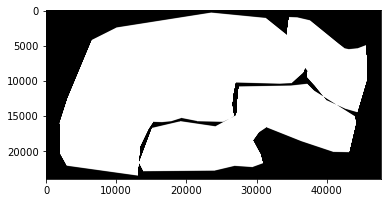

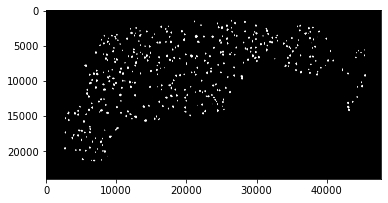

<class 'list'> 239 [[[ 3163 21523]
  [ 3094 21530]
  [ 3091 21532]
  [ 3091 21534]
  [ 3089 21536]
  [ 3088 21538]
  [ 3087 21539]
  [ 3085 21541]
  [ 3085 21542]
  [ 3084 21544]
  [ 3083 21546]
  [ 3080 21555]
  [ 3078 21561]
  [ 3077 21561]
  [ 3077 21568]
  [ 3077 21570]
  [ 3077 21571]
  [ 3076 21572]
  [ 3076 21574]
  [ 3075 21574]
  [ 3076 21575]
  [ 3076 21578]
  [ 3075 21580]
  [ 3075 21581]
  [ 3075 21582]
  [ 3075 21583]
  [ 3074 21585]
  [ 3074 21586]
  [ 3074 21587]
  [ 3074 21588]
  [ 3074 21591]
  [ 3074 21596]
  [ 3073 21598]
  [ 3073 21599]
  [ 3073 21600]
  [ 3073 21601]
  [ 3073 21604]
  [ 3073 21607]
  [ 3073 21610]
  [ 3073 21613]
  [ 3073 21616]
  [ 3073 21619]
  [ 3073 21622]
  [ 3073 21626]
  [ 3073 21629]
  [ 3073 21630]
  [ 3073 21631]
  [ 3073 21632]
  [ 3074 21634]
  [ 3074 21637]
  [ 3074 21641]
  [ 3074 21645]
  [ 3074 21650]
  [ 3074 21655]
  [ 3074 21658]
  [ 3074 21659]
  [ 3074 21660]
  [ 3074 21661]
  [ 3075 21663]
  [ 3075 21669]
  [ 3074 21669]
  [ 3

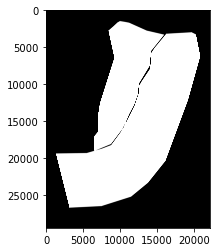

In [ ]:
import json
import cv2
import matplotlib.pyplot as plt
from PIL import Image
sum_score = 0
sum_pa = 0
sum_ji = 0
sum_haus = 0

for img in rles['id'].unique():
    shape = df_info[df_info.image_file == img + ".tiff"][['width_pixels', 'height_pixels']].values.astype(int)[0]
    mt = read_mask(path_test+img+'.json', (shape[1], shape[0]))
    mask_truth = 1*mt
    rle_truth = rles[rles['id'] == img]["encoding"]
    mask_truth_rle = enc2mask(rle_truth, shape)
    plt.imshow(mask_truth_rle, cmap="gray") 
    plt.show()

    pred = df[df['id'] == img]['predicted']
    mask_pred = enc2mask(pred, shape)  
    plt.imshow(mask_pred, cmap="gray") 
    plt.show()
    
#     print (mask_truth.shape, mask_truth_rle.shape)
#     print (np.sum(mask_truth != mask_truth_rle))
#     print (mask_truth, mask_truth_rle)
#     score = dice_scores_img(mask_pred, mask_truth_rle)
#     pa, ji, haus = perf_metrics(mask_pred, mask_truth)
#     print (score)
#     print (score,pa,ji,haus)
    
#     sum_score += score
#     sum_pa += pa
#     sum_ji += ji
#     sum_haus += haus[0]